In [1]:
import random
import numpy as np
from numpy.random import randn
from scipy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
# generate random data matrix
random.seed(0)
n,d = 6,4
X = randn(n,d)

# optional: give it linearly dependent columns
# X[:,3] = X[:,2]

In [3]:
# form data from noisy linear model
wtrue = randn(d)
y = X.dot(wtrue) + .1*randn(n)

In [4]:
# look at least squares objective as a function of w
def f(w):
    return norm(y - X.dot(w))**2

def gradf(w):
    return 2*X.T @ (X @ w) - 2*X.T @ y

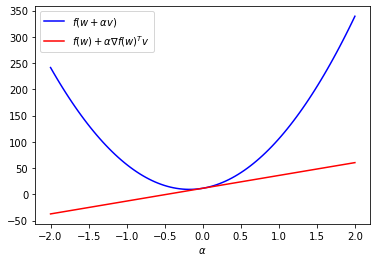

In [5]:
# gradient at w approximates f(w) near w
w = randn(d)
v = randn(d)
alphas = np.linspace(-2,2,100)
plt.plot(alphas, [f(w + alpha*v) for alpha in alphas], color='b', 
     label=r"$f(w + \alpha v)$")
plt.plot(alphas, [f(w) + alpha*gradf(w).dot(v) for alpha in alphas], color='r', 
      label=r"$f(w) + \alpha \nabla f(w)^T v$")
plt.xlabel(r"$\alpha$")
plt.legend()

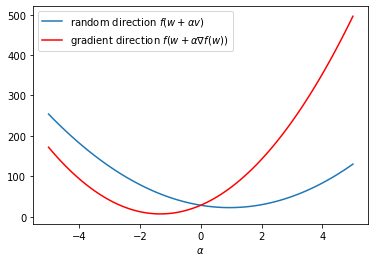

In [6]:
# function decreases fastest in the -∇f(w) direction
w = randn(d)
v = randn(d)
v_normalized = v/norm(v)
g = gradf(w)
g_normalized = g/norm(g)
alphas = np.linspace(-5,5,100)
plt.plot(alphas, [f(w + alpha*v_normalized) for alpha in alphas], 
     label = r"random direction $f(w + \alpha v)$")
plt.plot(alphas, [f(w + alpha*g_normalized) for alpha in alphas], color='r', 
         label= r"gradient direction $f(w + \alpha \nabla f(w))$")
plt.xlabel(r"$\alpha$")
plt.legend()
# notice: compared to blue line, red line always goes down faster to the left and up faster to the right

# gradient descent

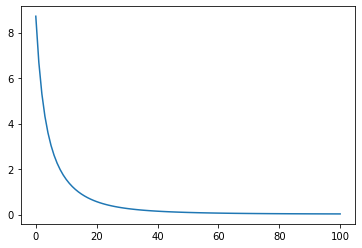

In [7]:
"""This function implements gradient descent for the function f with gradient ∇f"""
def gradient_descent(f, gradf,
                     alpha = .01,      # small constant step size - try other values!
                     w = np.zeros(d),     # start at a random w
                     maxiters = 100    # maximum number of iterations 
                     ):
    fks = []  # a list to record all the values f(w) we see
    fks.append(f(w)) # record the initial value

    # start descending!
    for k in range(maxiters):
        w = w - alpha*gradf(w)       # take a gradient step
        fks.append(f(w))             # record its value
    return w, fks

w, fks = gradient_descent(f, gradf, alpha = .01)

plt.plot(fks, label="sum of square errors")
#plt.semilogy(fks, label="sum of square errors")
#plt.loglog(fks, label="sum of square errors")

# Armijo rule

Text(0.5, 0, '$\\alpha$')

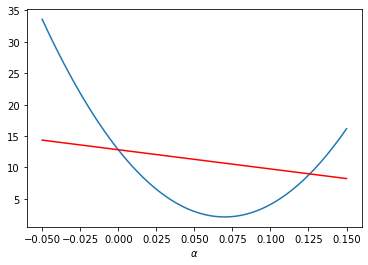

In [8]:
# function decreases fastest in the -∇f(w) direction
random.seed(1)

w = randn(d)
g = gradf(w)
c = .1
alphas = .05*np.linspace(-1,3,100)
plt.plot(alphas, [f(w - alpha*g) for alpha in alphas], 
     label = r"$f(w - \alpha \nabla f(w))$")
plt.plot(alphas, [f(w) - c*alpha*norm(g)**2 for alpha in alphas],color='r', 
         label=r"$f(w) - c\alpha \|\nabla f(w)\|^2$")
plt.xlabel(r"$\alpha$")


# Gradient descent with linesearch

Poll: gradient descent with linesearch will converge in ____ iterations than without
* A. more 
* B. fewer

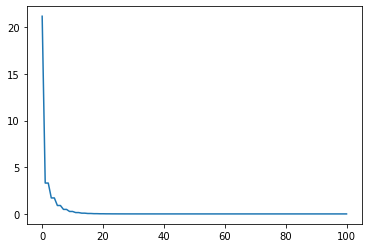

In [9]:
"""This function implements gradient descent with linesearch for the function f with gradient ∇f"""
def gradient_descent_linesearch(f, gradf,
                                alpha = 1,      # initial step size - try other values!
                                w = randn(d),     # start at a random w
                                maxiters = 100,   # maximum number of iterations 
                                c = .01            # Armijo sufficient decrease
                                ):

    fks = []  # a list to record all the values f(w) we see
    fw = f(w)
    fks.append(fw) # record the initial value
    g = gradf(w)
    alpha0 = alpha
    
    # start descending!
    for k in range(maxiters):
        w_new = w - alpha*g      # take a gradient step
        fw_new = f(w_new)
        while fw_new > fw - c*alpha*norm(g)**2:
            alpha /= 2
            w_new = w - alpha*g      # take a gradient step
            fw_new = f(w_new)
        w, fw, g = w_new, fw_new, gradf(w)
        alpha = alpha0
        fks.append(fw)
    return w, fks

w, fks = gradient_descent_linesearch(f, gradf, alpha = 1, c = .01)

plt.plot(fks, label="sum of square errors")
# plt.semilogy(fks, label="sum of square errors")
# plt.loglog(fks, label="sum of square errors")